In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgb
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
import numpy as np
import pandas as pd
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters ,ComprehensiveFCParameters
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
import timeit
import seaborn as sns
import sys
import time
from tqdm import tqdm
import warnings

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge

from sklearn.preprocessing import MinMaxScaler, StandardScaler,QuantileTransformer

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
warnings.filterwarnings("ignore")
np.seterr(divide='ignore', invalid='ignore')
np.seterr(divide='ignore')
# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

['test', 'train.csv', 'sample_submission.csv']


In [2]:
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

Import the data 

In [3]:
%matplotlib inline
start = time.time()
train = pd.read_csv('../input/train.csv',dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
end = time.time()
print(end - start)

0.40488243103027344


**This contains the features from the tsfresh library ComprehensiveFCParameters**

In [4]:
settings={'variance_larger_than_standard_deviation': None,
 'has_duplicate_max': None,
 'has_duplicate_min': None,
 'has_duplicate': None,
 'sum_values': None,
 'abs_energy': None,
 'mean_abs_change': None,
 'mean_change': None,
 'mean_second_derivative_central': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,
 'longest_strike_below_mean': None,
 'longest_strike_above_mean': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'first_location_of_minimum': None,
 'percentage_of_reoccurring_datapoints_to_all_datapoints': None,
 'percentage_of_reoccurring_values_to_all_values': None,
 'sum_of_reoccurring_values': None,
 'sum_of_reoccurring_data_points': None,
 'ratio_value_number_to_time_series_length': None,
 'sample_entropy': None,
 'maximum': None,
 'minimum': None,
 'time_reversal_asymmetry_statistic': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
 'cid_ce': [{'normalize': True}, {'normalize': False}],
 'symmetry_looking': [{'r': 0.0},
  {'r': 0.05},
  {'r': 0.1},
  {'r': 0.15000000000000002},
  {'r': 0.2},
  {'r': 0.25},
  {'r': 0.30000000000000004},
  {'r': 0.35000000000000003},
  {'r': 0.4},
  {'r': 0.45},
  {'r': 0.5},
  {'r': 0.55},
  {'r': 0.6000000000000001},
  {'r': 0.65},
  {'r': 0.7000000000000001},
  {'r': 0.75},
  {'r': 0.8},
  {'r': 0.8500000000000001},
  {'r': 0.9},
  {'r': 0.9500000000000001}],
 'large_standard_deviation': [{'r': 0.05},
  {'r': 0.1},
  {'r': 0.15000000000000002},
  {'r': 0.2},
  {'r': 0.25},
  {'r': 0.30000000000000004},
  {'r': 0.35000000000000003},
  {'r': 0.4},
  {'r': 0.45},
  {'r': 0.5},
  {'r': 0.55},
  {'r': 0.6000000000000001},
  {'r': 0.65},
  {'r': 0.7000000000000001},
  {'r': 0.75},
  {'r': 0.8},
  {'r': 0.8500000000000001},
  {'r': 0.9},
  {'r': 0.9500000000000001}],
 'quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'autocorrelation': [{'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 5},
  {'lag': 6},
  {'lag': 7},
  {'lag': 8},
  {'lag': 9}],
 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40},
  {'f_agg': 'median', 'maxlag': 40},
  {'f_agg': 'var', 'maxlag': 40}],
 'partial_autocorrelation': [{'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 5},
  {'lag': 6},
  {'lag': 7},
  {'lag': 8},
  {'lag': 9}],
 'number_cwt_peaks': [{'n': 1}, {'n': 5}],
 'number_peaks': [{'n': 1}, {'n': 3}, {'n': 5}, {'n': 10}, {'n': 50}],
 'binned_entropy': [{'max_bins': 10}],
 'index_mass_quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'cwt_coefficients': [{'widths': (2, 5, 10, 20), 'coeff': 0, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 0, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 0, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 0, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 1, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 1, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 1, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 1, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 2, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 2, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 2, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 2, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 3, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 3, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 3, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 3, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 4, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 4, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 4, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 4, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 5, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 5, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 5, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 5, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 6, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 6, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 6, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 6, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 7, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 7, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 7, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 7, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 8, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 8, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 8, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 8, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 9, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 9, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 9, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 9, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 10, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 10, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 10, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 10, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 11, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 11, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 11, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 11, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 12, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 12, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 12, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 12, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 13, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 13, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 13, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 13, 'w': 20},
  {'widths': (2, 5, 10, 20), 'coeff': 14, 'w': 2},
  {'widths': (2, 5, 10, 20), 'coeff': 14, 'w': 5},
  {'widths': (2, 5, 10, 20), 'coeff': 14, 'w': 10},
  {'widths': (2, 5, 10, 20), 'coeff': 14, 'w': 20}],
 'spkt_welch_density': [{'coeff': 2}, {'coeff': 5}, {'coeff': 8}],
 'ar_coefficient': [{'coeff': 0, 'k': 10},
  {'coeff': 1, 'k': 10},
  {'coeff': 2, 'k': 10},
  {'coeff': 3, 'k': 10},
  {'coeff': 4, 'k': 10}],
 'change_quantiles': [{'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.2, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.2, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.2, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.2, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.2, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.2, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.2, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.2, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.2, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.2, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.2, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.2, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 0.2, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 0.2, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 0.2, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 0.2, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'}],
 'fft_coefficient': [{'coeff': 0, 'attr': 'real'},
  {'coeff': 1, 'attr': 'real'},
  {'coeff': 2, 'attr': 'real'},
  {'coeff': 3, 'attr': 'real'},
  {'coeff': 4, 'attr': 'real'},
  {'coeff': 5, 'attr': 'real'},
  {'coeff': 6, 'attr': 'real'},
  {'coeff': 7, 'attr': 'real'},
  {'coeff': 8, 'attr': 'real'},
  {'coeff': 9, 'attr': 'real'},
  {'coeff': 10, 'attr': 'real'},
  {'coeff': 11, 'attr': 'real'},
  {'coeff': 12, 'attr': 'real'},
  {'coeff': 13, 'attr': 'real'},
  {'coeff': 14, 'attr': 'real'},
  {'coeff': 15, 'attr': 'real'},
  {'coeff': 16, 'attr': 'real'},
  {'coeff': 17, 'attr': 'real'},
  {'coeff': 18, 'attr': 'real'},
  {'coeff': 19, 'attr': 'real'},
  {'coeff': 20, 'attr': 'real'},
  {'coeff': 21, 'attr': 'real'},
  {'coeff': 22, 'attr': 'real'},
  {'coeff': 23, 'attr': 'real'},
  {'coeff': 24, 'attr': 'real'},
  {'coeff': 25, 'attr': 'real'},
  {'coeff': 26, 'attr': 'real'},
  {'coeff': 27, 'attr': 'real'},
  {'coeff': 28, 'attr': 'real'},
  {'coeff': 29, 'attr': 'real'},
  {'coeff': 30, 'attr': 'real'},
  {'coeff': 31, 'attr': 'real'},
  {'coeff': 32, 'attr': 'real'},
  {'coeff': 33, 'attr': 'real'},
  {'coeff': 34, 'attr': 'real'},
  {'coeff': 35, 'attr': 'real'},
  {'coeff': 36, 'attr': 'real'},
  {'coeff': 37, 'attr': 'real'},
  {'coeff': 38, 'attr': 'real'},
  {'coeff': 39, 'attr': 'real'},
  {'coeff': 40, 'attr': 'real'},
  {'coeff': 41, 'attr': 'real'},
  {'coeff': 42, 'attr': 'real'},
  {'coeff': 43, 'attr': 'real'},
  {'coeff': 44, 'attr': 'real'},
  {'coeff': 45, 'attr': 'real'},
  {'coeff': 46, 'attr': 'real'},
  {'coeff': 47, 'attr': 'real'},
  {'coeff': 48, 'attr': 'real'},
  {'coeff': 49, 'attr': 'real'},
  {'coeff': 50, 'attr': 'real'},
  {'coeff': 51, 'attr': 'real'},
  {'coeff': 52, 'attr': 'real'},
  {'coeff': 53, 'attr': 'real'},
  {'coeff': 54, 'attr': 'real'},
  {'coeff': 55, 'attr': 'real'},
  {'coeff': 56, 'attr': 'real'},
  {'coeff': 57, 'attr': 'real'},
  {'coeff': 58, 'attr': 'real'},
  {'coeff': 59, 'attr': 'real'},
  {'coeff': 60, 'attr': 'real'},
  {'coeff': 61, 'attr': 'real'},
  {'coeff': 62, 'attr': 'real'},
  {'coeff': 63, 'attr': 'real'},
  {'coeff': 64, 'attr': 'real'},
  {'coeff': 65, 'attr': 'real'},
  {'coeff': 66, 'attr': 'real'},
  {'coeff': 67, 'attr': 'real'},
  {'coeff': 68, 'attr': 'real'},
  {'coeff': 69, 'attr': 'real'},
  {'coeff': 70, 'attr': 'real'},
  {'coeff': 71, 'attr': 'real'},
  {'coeff': 72, 'attr': 'real'},
  {'coeff': 73, 'attr': 'real'},
  {'coeff': 74, 'attr': 'real'},
  {'coeff': 75, 'attr': 'real'},
  {'coeff': 76, 'attr': 'real'},
  {'coeff': 77, 'attr': 'real'},
  {'coeff': 78, 'attr': 'real'},
  {'coeff': 79, 'attr': 'real'},
  {'coeff': 80, 'attr': 'real'},
  {'coeff': 81, 'attr': 'real'},
  {'coeff': 82, 'attr': 'real'},
  {'coeff': 83, 'attr': 'real'},
  {'coeff': 84, 'attr': 'real'},
  {'coeff': 85, 'attr': 'real'},
  {'coeff': 86, 'attr': 'real'},
  {'coeff': 87, 'attr': 'real'},
  {'coeff': 88, 'attr': 'real'},
  {'coeff': 89, 'attr': 'real'},
  {'coeff': 90, 'attr': 'real'},
  {'coeff': 91, 'attr': 'real'},
  {'coeff': 92, 'attr': 'real'},
  {'coeff': 93, 'attr': 'real'},
  {'coeff': 94, 'attr': 'real'},
  {'coeff': 95, 'attr': 'real'},
  {'coeff': 96, 'attr': 'real'},
  {'coeff': 97, 'attr': 'real'},
  {'coeff': 98, 'attr': 'real'},
  {'coeff': 99, 'attr': 'real'},
  {'coeff': 0, 'attr': 'imag'},
  {'coeff': 1, 'attr': 'imag'},
  {'coeff': 2, 'attr': 'imag'},
  {'coeff': 3, 'attr': 'imag'},
  {'coeff': 4, 'attr': 'imag'},
  {'coeff': 5, 'attr': 'imag'},
  {'coeff': 6, 'attr': 'imag'},
  {'coeff': 7, 'attr': 'imag'},
  {'coeff': 8, 'attr': 'imag'},
  {'coeff': 9, 'attr': 'imag'},
  {'coeff': 10, 'attr': 'imag'},
  {'coeff': 11, 'attr': 'imag'},
  {'coeff': 12, 'attr': 'imag'},
  {'coeff': 13, 'attr': 'imag'},
  {'coeff': 14, 'attr': 'imag'},
  {'coeff': 15, 'attr': 'imag'},
  {'coeff': 16, 'attr': 'imag'},
  {'coeff': 17, 'attr': 'imag'},
  {'coeff': 18, 'attr': 'imag'},
  {'coeff': 19, 'attr': 'imag'},
  {'coeff': 20, 'attr': 'imag'},
  {'coeff': 21, 'attr': 'imag'},
  {'coeff': 22, 'attr': 'imag'},
  {'coeff': 23, 'attr': 'imag'},
  {'coeff': 24, 'attr': 'imag'},
  {'coeff': 25, 'attr': 'imag'},
  {'coeff': 26, 'attr': 'imag'},
  {'coeff': 27, 'attr': 'imag'},
  {'coeff': 28, 'attr': 'imag'},
  {'coeff': 29, 'attr': 'imag'},
  {'coeff': 30, 'attr': 'imag'},
  {'coeff': 31, 'attr': 'imag'},
  {'coeff': 32, 'attr': 'imag'},
  {'coeff': 33, 'attr': 'imag'},
  {'coeff': 34, 'attr': 'imag'},
  {'coeff': 35, 'attr': 'imag'},
  {'coeff': 36, 'attr': 'imag'},
  {'coeff': 37, 'attr': 'imag'},
  {'coeff': 38, 'attr': 'imag'},
  {'coeff': 39, 'attr': 'imag'},
  {'coeff': 40, 'attr': 'imag'},
  {'coeff': 41, 'attr': 'imag'},
  {'coeff': 42, 'attr': 'imag'},
  {'coeff': 43, 'attr': 'imag'},
  {'coeff': 44, 'attr': 'imag'},
  {'coeff': 45, 'attr': 'imag'},
  {'coeff': 46, 'attr': 'imag'},
  {'coeff': 47, 'attr': 'imag'},
  {'coeff': 48, 'attr': 'imag'},
  {'coeff': 49, 'attr': 'imag'},
  {'coeff': 50, 'attr': 'imag'},
  {'coeff': 51, 'attr': 'imag'},
  {'coeff': 52, 'attr': 'imag'},
  {'coeff': 53, 'attr': 'imag'},
  {'coeff': 54, 'attr': 'imag'},
  {'coeff': 55, 'attr': 'imag'},
  {'coeff': 56, 'attr': 'imag'},
  {'coeff': 57, 'attr': 'imag'},
  {'coeff': 58, 'attr': 'imag'},
  {'coeff': 59, 'attr': 'imag'},
  {'coeff': 60, 'attr': 'imag'},
  {'coeff': 61, 'attr': 'imag'},
  {'coeff': 62, 'attr': 'imag'},
  {'coeff': 63, 'attr': 'imag'},
  {'coeff': 64, 'attr': 'imag'},
  {'coeff': 65, 'attr': 'imag'},
  {'coeff': 66, 'attr': 'imag'},
  {'coeff': 67, 'attr': 'imag'},
  {'coeff': 68, 'attr': 'imag'},
  {'coeff': 69, 'attr': 'imag'},
  {'coeff': 70, 'attr': 'imag'},
  {'coeff': 71, 'attr': 'imag'},
  {'coeff': 72, 'attr': 'imag'},
  {'coeff': 73, 'attr': 'imag'},
  {'coeff': 74, 'attr': 'imag'},
  {'coeff': 75, 'attr': 'imag'},
  {'coeff': 76, 'attr': 'imag'},
  {'coeff': 77, 'attr': 'imag'},
  {'coeff': 78, 'attr': 'imag'},
  {'coeff': 79, 'attr': 'imag'},
  {'coeff': 80, 'attr': 'imag'},
  {'coeff': 81, 'attr': 'imag'},
  {'coeff': 82, 'attr': 'imag'},
  {'coeff': 83, 'attr': 'imag'},
  {'coeff': 84, 'attr': 'imag'},
  {'coeff': 85, 'attr': 'imag'},
  {'coeff': 86, 'attr': 'imag'},
  {'coeff': 87, 'attr': 'imag'},
  {'coeff': 88, 'attr': 'imag'},
  {'coeff': 89, 'attr': 'imag'},
  {'coeff': 90, 'attr': 'imag'},
  {'coeff': 91, 'attr': 'imag'},
  {'coeff': 92, 'attr': 'imag'},
  {'coeff': 93, 'attr': 'imag'},
  {'coeff': 94, 'attr': 'imag'},
  {'coeff': 95, 'attr': 'imag'},
  {'coeff': 96, 'attr': 'imag'},
  {'coeff': 97, 'attr': 'imag'},
  {'coeff': 98, 'attr': 'imag'},
  {'coeff': 99, 'attr': 'imag'},
  {'coeff': 0, 'attr': 'abs'},
  {'coeff': 1, 'attr': 'abs'},
  {'coeff': 2, 'attr': 'abs'},
  {'coeff': 3, 'attr': 'abs'},
  {'coeff': 4, 'attr': 'abs'},
  {'coeff': 5, 'attr': 'abs'},
  {'coeff': 6, 'attr': 'abs'},
  {'coeff': 7, 'attr': 'abs'},
  {'coeff': 8, 'attr': 'abs'},
  {'coeff': 9, 'attr': 'abs'},
  {'coeff': 10, 'attr': 'abs'},
  {'coeff': 11, 'attr': 'abs'},
  {'coeff': 12, 'attr': 'abs'},
  {'coeff': 13, 'attr': 'abs'},
  {'coeff': 14, 'attr': 'abs'},
  {'coeff': 15, 'attr': 'abs'},
  {'coeff': 16, 'attr': 'abs'},
  {'coeff': 17, 'attr': 'abs'},
  {'coeff': 18, 'attr': 'abs'},
  {'coeff': 19, 'attr': 'abs'},
  {'coeff': 20, 'attr': 'abs'},
  {'coeff': 21, 'attr': 'abs'},
  {'coeff': 22, 'attr': 'abs'},
  {'coeff': 23, 'attr': 'abs'},
  {'coeff': 24, 'attr': 'abs'},
  {'coeff': 25, 'attr': 'abs'},
  {'coeff': 26, 'attr': 'abs'},
  {'coeff': 27, 'attr': 'abs'},
  {'coeff': 28, 'attr': 'abs'},
  {'coeff': 29, 'attr': 'abs'},
  {'coeff': 30, 'attr': 'abs'},
  {'coeff': 31, 'attr': 'abs'},
  {'coeff': 32, 'attr': 'abs'},
  {'coeff': 33, 'attr': 'abs'},
  {'coeff': 34, 'attr': 'abs'},
  {'coeff': 35, 'attr': 'abs'},
  {'coeff': 36, 'attr': 'abs'},
  {'coeff': 37, 'attr': 'abs'},
  {'coeff': 38, 'attr': 'abs'},
  {'coeff': 39, 'attr': 'abs'},
  {'coeff': 40, 'attr': 'abs'},
  {'coeff': 41, 'attr': 'abs'},
  {'coeff': 42, 'attr': 'abs'},
  {'coeff': 43, 'attr': 'abs'},
  {'coeff': 44, 'attr': 'abs'},
  {'coeff': 45, 'attr': 'abs'},
  {'coeff': 46, 'attr': 'abs'},
  {'coeff': 47, 'attr': 'abs'},
  {'coeff': 48, 'attr': 'abs'},
  {'coeff': 49, 'attr': 'abs'},
  {'coeff': 50, 'attr': 'abs'},
  {'coeff': 51, 'attr': 'abs'},
  {'coeff': 52, 'attr': 'abs'},
  {'coeff': 53, 'attr': 'abs'},
  {'coeff': 54, 'attr': 'abs'},
  {'coeff': 55, 'attr': 'abs'},
  {'coeff': 56, 'attr': 'abs'},
  {'coeff': 57, 'attr': 'abs'},
  {'coeff': 58, 'attr': 'abs'},
  {'coeff': 59, 'attr': 'abs'},
  {'coeff': 60, 'attr': 'abs'},
  {'coeff': 61, 'attr': 'abs'},
  {'coeff': 62, 'attr': 'abs'},
  {'coeff': 63, 'attr': 'abs'},
  {'coeff': 64, 'attr': 'abs'},
  {'coeff': 65, 'attr': 'abs'},
  {'coeff': 66, 'attr': 'abs'},
  {'coeff': 67, 'attr': 'abs'},
  {'coeff': 68, 'attr': 'abs'},
  {'coeff': 69, 'attr': 'abs'},
  {'coeff': 70, 'attr': 'abs'},
  {'coeff': 71, 'attr': 'abs'},
  {'coeff': 72, 'attr': 'abs'},
  {'coeff': 73, 'attr': 'abs'},
  {'coeff': 74, 'attr': 'abs'},
  {'coeff': 75, 'attr': 'abs'},
  {'coeff': 76, 'attr': 'abs'},
  {'coeff': 77, 'attr': 'abs'},
  {'coeff': 78, 'attr': 'abs'},
  {'coeff': 79, 'attr': 'abs'},
  {'coeff': 80, 'attr': 'abs'},
  {'coeff': 81, 'attr': 'abs'},
  {'coeff': 82, 'attr': 'abs'},
  {'coeff': 83, 'attr': 'abs'},
  {'coeff': 84, 'attr': 'abs'},
  {'coeff': 85, 'attr': 'abs'},
  {'coeff': 86, 'attr': 'abs'},
  {'coeff': 87, 'attr': 'abs'},
  {'coeff': 88, 'attr': 'abs'},
  {'coeff': 89, 'attr': 'abs'},
  {'coeff': 90, 'attr': 'abs'},
  {'coeff': 91, 'attr': 'abs'},
  {'coeff': 92, 'attr': 'abs'},
  {'coeff': 93, 'attr': 'abs'},
  {'coeff': 94, 'attr': 'abs'},
  {'coeff': 95, 'attr': 'abs'},
  {'coeff': 96, 'attr': 'abs'},
  {'coeff': 97, 'attr': 'abs'},
  {'coeff': 98, 'attr': 'abs'},
  {'coeff': 99, 'attr': 'abs'},
  {'coeff': 0, 'attr': 'angle'},
  {'coeff': 1, 'attr': 'angle'},
  {'coeff': 2, 'attr': 'angle'},
  {'coeff': 3, 'attr': 'angle'},
  {'coeff': 4, 'attr': 'angle'},
  {'coeff': 5, 'attr': 'angle'},
  {'coeff': 6, 'attr': 'angle'},
  {'coeff': 7, 'attr': 'angle'},
  {'coeff': 8, 'attr': 'angle'},
  {'coeff': 9, 'attr': 'angle'},
  {'coeff': 10, 'attr': 'angle'},
  {'coeff': 11, 'attr': 'angle'},
  {'coeff': 12, 'attr': 'angle'},
  {'coeff': 13, 'attr': 'angle'},
  {'coeff': 14, 'attr': 'angle'},
  {'coeff': 15, 'attr': 'angle'},
  {'coeff': 16, 'attr': 'angle'},
  {'coeff': 17, 'attr': 'angle'},
  {'coeff': 18, 'attr': 'angle'},
  {'coeff': 19, 'attr': 'angle'},
  {'coeff': 20, 'attr': 'angle'},
  {'coeff': 21, 'attr': 'angle'},
  {'coeff': 22, 'attr': 'angle'},
  {'coeff': 23, 'attr': 'angle'},
  {'coeff': 24, 'attr': 'angle'},
  {'coeff': 25, 'attr': 'angle'},
  {'coeff': 26, 'attr': 'angle'},
  {'coeff': 27, 'attr': 'angle'},
  {'coeff': 28, 'attr': 'angle'},
  {'coeff': 29, 'attr': 'angle'},
  {'coeff': 30, 'attr': 'angle'},
  {'coeff': 31, 'attr': 'angle'},
  {'coeff': 32, 'attr': 'angle'},
  {'coeff': 33, 'attr': 'angle'},
  {'coeff': 34, 'attr': 'angle'},
  {'coeff': 35, 'attr': 'angle'},
  {'coeff': 36, 'attr': 'angle'},
  {'coeff': 37, 'attr': 'angle'},
  {'coeff': 38, 'attr': 'angle'},
  {'coeff': 39, 'attr': 'angle'},
  {'coeff': 40, 'attr': 'angle'},
  {'coeff': 41, 'attr': 'angle'},
  {'coeff': 42, 'attr': 'angle'},
  {'coeff': 43, 'attr': 'angle'},
  {'coeff': 44, 'attr': 'angle'},
  {'coeff': 45, 'attr': 'angle'},
  {'coeff': 46, 'attr': 'angle'},
  {'coeff': 47, 'attr': 'angle'},
  {'coeff': 48, 'attr': 'angle'},
  {'coeff': 49, 'attr': 'angle'},
  {'coeff': 50, 'attr': 'angle'},
  {'coeff': 51, 'attr': 'angle'},
  {'coeff': 52, 'attr': 'angle'},
  {'coeff': 53, 'attr': 'angle'},
  {'coeff': 54, 'attr': 'angle'},
  {'coeff': 55, 'attr': 'angle'},
  {'coeff': 56, 'attr': 'angle'},
  {'coeff': 57, 'attr': 'angle'},
  {'coeff': 58, 'attr': 'angle'},
  {'coeff': 59, 'attr': 'angle'},
  {'coeff': 60, 'attr': 'angle'},
  {'coeff': 61, 'attr': 'angle'},
  {'coeff': 62, 'attr': 'angle'},
  {'coeff': 63, 'attr': 'angle'},
  {'coeff': 64, 'attr': 'angle'},
  {'coeff': 65, 'attr': 'angle'},
  {'coeff': 66, 'attr': 'angle'},
  {'coeff': 67, 'attr': 'angle'},
  {'coeff': 68, 'attr': 'angle'},
  {'coeff': 69, 'attr': 'angle'},
  {'coeff': 70, 'attr': 'angle'},
  {'coeff': 71, 'attr': 'angle'},
  {'coeff': 72, 'attr': 'angle'},
  {'coeff': 73, 'attr': 'angle'},
  {'coeff': 74, 'attr': 'angle'},
  {'coeff': 75, 'attr': 'angle'},
  {'coeff': 76, 'attr': 'angle'},
  {'coeff': 77, 'attr': 'angle'},
  {'coeff': 78, 'attr': 'angle'},
  {'coeff': 79, 'attr': 'angle'},
  {'coeff': 80, 'attr': 'angle'},
  {'coeff': 81, 'attr': 'angle'},
  {'coeff': 82, 'attr': 'angle'},
  {'coeff': 83, 'attr': 'angle'},
  {'coeff': 84, 'attr': 'angle'},
  {'coeff': 85, 'attr': 'angle'},
  {'coeff': 86, 'attr': 'angle'},
  {'coeff': 87, 'attr': 'angle'},
  {'coeff': 88, 'attr': 'angle'},
  {'coeff': 89, 'attr': 'angle'},
  {'coeff': 90, 'attr': 'angle'},
  {'coeff': 91, 'attr': 'angle'},
  {'coeff': 92, 'attr': 'angle'},
  {'coeff': 93, 'attr': 'angle'},
  {'coeff': 94, 'attr': 'angle'},
  {'coeff': 95, 'attr': 'angle'},
  {'coeff': 96, 'attr': 'angle'},
  {'coeff': 97, 'attr': 'angle'},
  {'coeff': 98, 'attr': 'angle'},
  {'coeff': 99, 'attr': 'angle'}],
 'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}],
 'value_count': [{'value': 0}, {'value': 1}, {'value': -1}],
 'range_count': [{'min': -1, 'max': 1},
  {'min': 1000000000000.0, 'max': 0},
  {'min': 0, 'max': 1000000000000.0}],
 'approximate_entropy': [{'m': 2, 'r': 0.1},
  {'m': 2, 'r': 0.3},
  {'m': 2, 'r': 0.5},
  {'m': 2, 'r': 0.7},
  {'m': 2, 'r': 0.9}],
 'friedrich_coefficients': [{'coeff': 0, 'm': 3, 'r': 30},
  {'coeff': 1, 'm': 3, 'r': 30},
  {'coeff': 2, 'm': 3, 'r': 30},
  {'coeff': 3, 'm': 3, 'r': 30}],
 'max_langevin_fixed_point': [{'m': 3, 'r': 30}],
 'linear_trend': [{'attr': 'pvalue'},
  {'attr': 'rvalue'},
  {'attr': 'intercept'},
  {'attr': 'slope'},
  {'attr': 'stderr'}],
 'agg_linear_trend': [{'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'var'}],
 'augmented_dickey_fuller': [{'attr': 'teststat'},
  {'attr': 'pvalue'},
  {'attr': 'usedlag'}],
 'number_crossing_m': [{'m': 0}, {'m': -1}, {'m': 1}],
 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0},
  {'num_segments': 10, 'segment_focus': 1},
  {'num_segments': 10, 'segment_focus': 2},
  {'num_segments': 10, 'segment_focus': 3},
  {'num_segments': 10, 'segment_focus': 4},
  {'num_segments': 10, 'segment_focus': 5},
  {'num_segments': 10, 'segment_focus': 6},
  {'num_segments': 10, 'segment_focus': 7},
  {'num_segments': 10, 'segment_focus': 8},
  {'num_segments': 10, 'segment_focus': 9}],
 'ratio_beyond_r_sigma': [{'r': 0.5},
  {'r': 1},
  {'r': 1.5},
  {'r': 2},
  {'r': 2.5},
  {'r': 3},
  {'r': 5},
  {'r': 6},
  {'r': 7},
  {'r': 10}]}

**Choose some features from the list above.
(Remove features which take an unreasonable amount of time to calculate)**

In [5]:
settings={
'standard_deviation': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,

'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
'first_location_of_minimum': None,
'count_above_mean': None,
 'count_below_mean': None,
 'maximum': None,
 'minimum': None,

    
 'c3': [{'lag': 100}, {'lag': 2000}, {'lag': 3000},{'lag': 10000}],

'number_peaks': [{'n': 1}, {'n': 5},{'n': 100},{'n': 1000}],
'fft_coefficient': 
 [{'coeff': 0, 'attr': 'real'},
  {'coeff': 1, 'attr': 'real'},
  {'coeff': 2, 'attr': 'real'},
  {'coeff': 3, 'attr': 'real'},
  {'coeff': 4, 'attr': 'real'},

  {'coeff': 0, 'attr': 'imag'},
  {'coeff': 1, 'attr': 'imag'},
  {'coeff': 2, 'attr': 'imag'},
  {'coeff': 3, 'attr': 'imag'},
  {'coeff': 4, 'attr': 'imag'},
  {'coeff': 5, 'attr': 'imag'},

  {'coeff': 0, 'attr': 'abs'},
  {'coeff': 1, 'attr': 'abs'},
  {'coeff': 2, 'attr': 'abs'},
  {'coeff': 3, 'attr': 'abs'},
  {'coeff': 4, 'attr': 'abs'},
  {'coeff': 5, 'attr': 'abs'},

  {'coeff': 0, 'attr': 'angle'},
  {'coeff': 1, 'attr': 'angle'},
  {'coeff': 2, 'attr': 'angle'},
  {'coeff': 3, 'attr': 'angle'},
  {'coeff': 4, 'attr': 'angle'},
  {'coeff': 5, 'attr': 'angle'},
],
 'agg_linear_trend': [
     {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 5000, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 5000, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 5000, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 5000, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 5000, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 5000, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 5000, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 5000, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 5000, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 5000, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 5000, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 5000, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 5000, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 5000, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 5000, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 5000, 'f_agg': 'var'}],
 'index_mass_quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],

 'spkt_welch_density': [{'coeff': 2}, {'coeff': 5}, {'coeff': 8}],
 'ar_coefficient': [{'coeff': 0, 'k': 10},
  {'coeff': 1, 'k': 10},
  {'coeff': 2, 'k': 10},
  {'coeff': 3, 'k': 10},
  {'coeff': 4, 'k': 10}],

 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0},
  {'num_segments': 10, 'segment_focus': 1},
  {'num_segments': 10, 'segment_focus': 2},
  {'num_segments': 10, 'segment_focus': 3},
  {'num_segments': 10, 'segment_focus': 4},
  {'num_segments': 10, 'segment_focus': 5},
  {'num_segments': 10, 'segment_focus': 6},
  {'num_segments': 10, 'segment_focus': 7},
  {'num_segments': 10, 'segment_focus': 8},
  {'num_segments': 10, 'segment_focus': 9}],
 'ratio_beyond_r_sigma': [{'r': 0.5},
  {'r': 1},
  {'r': 1.5},
  {'r': 2},
  {'r': 2.5},
  {'r': 3},
  {'r': 5},
  {'r': 6},
  {'r': 7},
  {'r': 10}],
'max_langevin_fixed_point': [{'m': 3, 'r': 30}],
    'change_quantiles': [{'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'}]

}

In [6]:

train_t=train[:150000]
train_t=pd.concat([pd.DataFrame({'id': np.ones(train_t.shape[0])}, dtype=np.int16),
                   pd.DataFrame({'time': range(train_t.shape[0])}, dtype=np.int32),
                   train_t.iloc[:,0]],axis=1)

print(train_t.shape)
print(train_t.head())

(150000, 3)
   id  time  acoustic_data
0   1     0             12
1   1     1              6
2   1     2              8
3   1     3              5
4   1     4              8


**Calculate relative time spent for every feature**

In [7]:
res  = pd.DataFrame()
n_ts = 20
l_ts = 1000
n_ti = 3

def tsfresh_time(sett):
    for f, param in tqdm(sett.items()):
        res.loc[f, "feature"] = f
        res.loc[f, "n_samp"] = n_ts
        res.loc[f, "length"] = l_ts

        fc_dict = {f:param}

        t = timeit.timeit(lambda : extract_features(train_t, 
                         column_id='id',
                         column_sort='time',
                         column_value="acoustic_data",
                         n_jobs=1, 
                         default_fc_parameters=fc_dict, 
                         disable_progressbar=True), 
                          number=n_ti)
        n_fs = 1
        res.loc[f, "n_fs"] = n_fs
        res.loc[f, "t_abs"] = t * 1.0/n_fs
        res.loc[f, "t_1ts"] = t*1.0/(n_ts*n_fs)
    return res


100%|██████████| 24/24 [00:38<00:00,  6.35s/it]


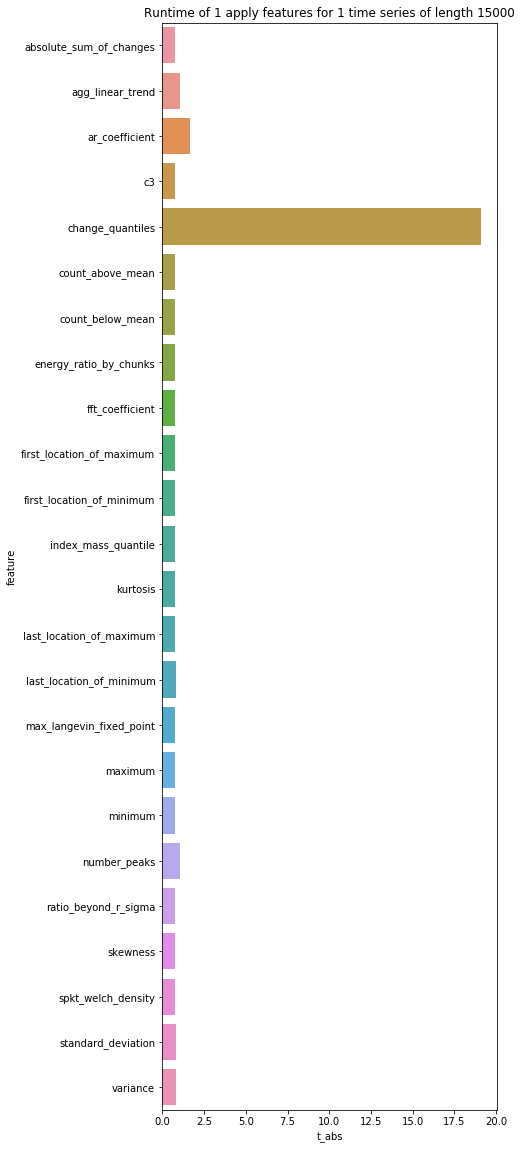

In [8]:
res=pd.DataFrame()
res=tsfresh_time(settings)
res["feature"] = res.feature.astype(str)
res = res.sort_values(by="feature")

plt.figure(figsize=(6, 20))
sns.barplot(y="feature", x="t_abs", data=res)
plt.title("Runtime of 1 apply features for 1 time series of length 15000")
plt.show()

**Define features which are going to be used for the final feature extraction.**

In [11]:
settings={
'standard_deviation': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,

 'count_above_mean': None,
 'count_below_mean': None,
'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
'first_location_of_minimum': None,

 'maximum': None,
 'minimum': None,

 'c3': [{'lag': 100}, {'lag': 2000}, {'lag': 3000},{'lag': 10000}],

'number_peaks': [{'n': 1}, 
                  {'n': 3}, 
                  {'n': 5},{'n': 100},{'n': 5000}],
'fft_coefficient': 
 [{'coeff': 0, 'attr': 'real'},
  {'coeff': 1, 'attr': 'real'},
  {'coeff': 2, 'attr': 'real'},
  {'coeff': 3, 'attr': 'real'},
  {'coeff': 4, 'attr': 'real'},

  {'coeff': 0, 'attr': 'imag'},
  {'coeff': 1, 'attr': 'imag'},
  {'coeff': 2, 'attr': 'imag'},
  {'coeff': 3, 'attr': 'imag'},
  {'coeff': 4, 'attr': 'imag'},
  {'coeff': 5, 'attr': 'imag'},

  {'coeff': 0, 'attr': 'abs'},
  {'coeff': 1, 'attr': 'abs'},
  {'coeff': 2, 'attr': 'abs'},
  {'coeff': 3, 'attr': 'abs'},
  {'coeff': 4, 'attr': 'abs'},
  {'coeff': 5, 'attr': 'abs'},

  {'coeff': 0, 'attr': 'angle'},
  {'coeff': 1, 'attr': 'angle'},
  {'coeff': 2, 'attr': 'angle'},
  {'coeff': 3, 'attr': 'angle'},
  {'coeff': 4, 'attr': 'angle'},
  {'coeff': 5, 'attr': 'angle'},
],
 'agg_linear_trend': [
     {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 5000, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 5000, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 5000, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 5000, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 5000, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 5000, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 5000, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 5000, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 5000, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 5000, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 5000, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 5000, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 5000, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 5000, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 5000, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 5000, 'f_agg': 'var'}],
 'index_mass_quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],

 'spkt_welch_density': [{'coeff': 2}, {'coeff': 5}, {'coeff': 8}],
 'ar_coefficient': [{'coeff': 0, 'k': 10},
  {'coeff': 1, 'k': 10},
  {'coeff': 2, 'k': 10},
  {'coeff': 3, 'k': 10},
  {'coeff': 4, 'k': 10}],

 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0},
  {'num_segments': 10, 'segment_focus': 1},
  {'num_segments': 10, 'segment_focus': 2},
  {'num_segments': 10, 'segment_focus': 3},
  {'num_segments': 10, 'segment_focus': 4},
  {'num_segments': 10, 'segment_focus': 5},
  {'num_segments': 10, 'segment_focus': 6},
  {'num_segments': 10, 'segment_focus': 7},
  {'num_segments': 10, 'segment_focus': 8},
  {'num_segments': 10, 'segment_focus': 9}],
 'ratio_beyond_r_sigma': [{'r': 0.5},
  {'r': 1},
  {'r': 1.5},
  {'r': 2},
  {'r': 2.5},
  {'r': 3},
  {'r': 5},
  {'r': 6},
  {'r': 7},
  {'r': 10}],
'max_langevin_fixed_point': [{'m': 3, 'r': 30}],

}
peak={
'number_peaks': [{'n': 1}, 
                  {'n': 3}, 
                  {'n': 5}, 
                  {'n': 10}]}


100%|██████████| 22/22 [00:19<00:00,  1.11it/s]


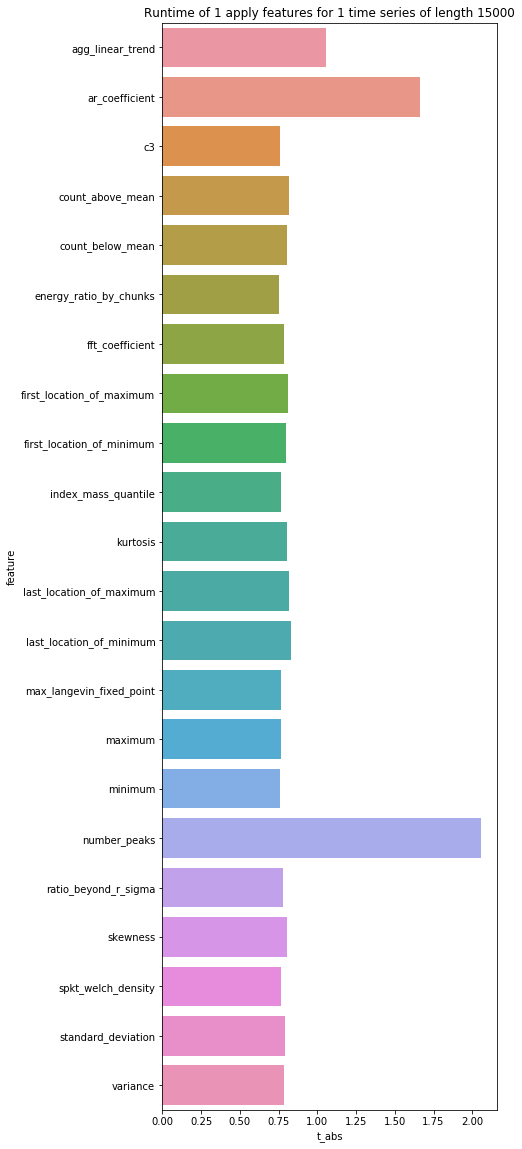

In [13]:
res=pd.DataFrame()
res=tsfresh_time(settings)
res["feature"] = res.feature.astype(str)
res = res.sort_values(by="feature")

plt.figure(figsize=(6, 20))
sns.barplot(y="feature", x="t_abs", data=res)
plt.title("Runtime of 1 apply features for 1 time series of length 15000")
plt.show()

**Feature Extraction for segments of length 150,000. Also each segment is divided into 4 sections of 37500 in length where the ts_features(train1,settings)function is used.**

In [ ]:
start = time.time()

# Create a training file with simple derived features
n = 150000
parts=37500
segments = ((len(train) + n - 1)//n)-1
ids = pd.DataFrame({'id': np.ones(n)}, dtype=np.int16)
times = pd.DataFrame({'time': range(n)}, dtype=np.int32)
X_filtered = pd.DataFrame()
y_tr = pd.DataFrame(index=range(segments), dtype=np.float64, 
                    columns=['time_to_failure'])


def ts_features(train1,settings):
    X=extract_features(train1, 
                     column_id='id',
                     column_sort='time',
                     column_value="acoustic_data",
                     default_fc_parameters=settings,
                     #impute_function= impute,
                     disable_progressbar=True,
                     show_warnings=True)
    return X

for i in progressbar(range(segments), "Computing: ", 40):  
    X1 = pd.DataFrame()
    train1=pd.concat([ids,times,train[i * n:(i + 1) *n].reset_index(drop=True)],axis=1)
    seg = train[i*n:(i + 1)*n]
    y = seg['time_to_failure'].values[-1]
    y_tr.loc[i, 'time_to_failure'] = y
    
    #Features in whole segment
    X2=ts_features(train1,peak)
    #Features per section 4x37500
    for j in range(4):
        
        X=ts_features(train1[j * parts:(j + 1) *parts],settings).add_prefix('q_' +str(j))
        X1=pd.concat([X1,X], axis=1)
   
    #print(X1.shape)
    X_filtered=X_filtered.append(pd.concat([X1,X2], axis=1))
    

X_filtered=X_filtered.reset_index().drop(['id'], axis=1)
print(X_filtered.shape)
print(y_tr.shape)
del train

end = time.time()
print("Time",end - start)


**Feature Extraction for submission**

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
start = time.time()
X_testfresh = pd.DataFrame()
# Load each test data, create the feature matrix, get numeric prediction
for i in progressbar(range(len(submission)), "Computing: ", 40):
  #  print(i)
    X1 = pd.DataFrame()
    ids = pd.DataFrame({'id': [submission.index[i] for number in range(n)]}, dtype=np.int16)
    seg = pd.read_csv('../input/test/' + submission.index[i] + '.csv' )
    x = seg['acoustic_data']
    test=pd.concat([ids,times,x],axis=1)
    
    #Features in whole segment
    X2=ts_features(test,peak)
    #Features per section 5x30000
    for j in range(4):
        X=ts_features(test[j * parts:(j + 1) *parts],settings).add_prefix('q_' +str(j))
        X1=pd.concat([X1,X], axis=1)
    #print(X1.shape)
    X_testfresh=X_testfresh.append(pd.concat([X1,X2], axis=1))
end = time.time()
print("Time",end - start)


**Filtering Data to remove repeating values as well as N/A values.**

In [ ]:
dfb=X_filtered.reset_index(drop=True).append(X_testfresh)
dfb.to_csv('unfiltered.csv',index=False)
print(dfb.shape)
dfb=dfb.dropna(axis='columns')
dfb=dfb.loc[:, (dfb != dfb.iloc[0]).any()] 
print(dfb.shape)
dfb.head()

In [ ]:
df=pd.concat([y_tr,dfb[:X_filtered.shape[0]]], axis=1)
df.to_csv('tsfreshFeaturestrain.csv',index=False)
test=dfb[-X_testfresh.shape[0]:]
test.to_csv('tsfreshFeaturestest.csv',index=False)

X=df[df.columns.difference(['time_to_failure'])]
y=df['time_to_failure']

#Scaling train and test features at the same time
scaler=MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit_transform(X.append(test))

train=pd.DataFrame(scaled[:X.shape[0]], columns=X.columns.values)
test=pd.DataFrame(scaled[-test.shape[0]:], columns=X.columns.values)
trainX, testX, trainy, testy = train_test_split(train, y, test_size=0.0,shuffle=True)


**Regression with GBM and LightGBM**

In [ ]:


model = GradientBoostingRegressor(learning_rate=0.009, loss='huber',max_depth=5,max_features=150,n_estimators=650)
num_folds = 5
cross_validate_results = cross_validate(model, trainX, trainy, n_jobs=-1, return_estimator= True, return_train_score=True, cv=num_folds,  scoring="neg_mean_absolute_error" )

for i in range(num_folds):
    print("Fold: {} Training MAE: {}".format(i,-cross_validate_results['train_score'][i]))
    print("Fold: {} Validation MAE: {}".format(i,-cross_validate_results['test_score'][i]))
print(-cross_validate_results['train_score'].mean(), cross_validate_results['train_score'].std())
print(-cross_validate_results['test_score'].mean(), cross_validate_results['test_score'].std())

model.fit(trainX, trainy)
data=pd.concat([pd.DataFrame(X.columns.values,columns={'Features'}),
           pd.DataFrame(model.feature_importances_,columns={'Importance'})*100],
               axis=1).sort_values(by='Importance', ascending=False)

data.to_csv('FeaturesImportance.csv',index=False)

plt.figure(figsize=(6, 20))
sns.barplot(y="Features", x="Importance", data=data[:150])
plt.title("Features")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = np.array([])
predictions1 = np.zeros(len(test))
feature_importance_df = pd.DataFrame()
#run model

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = trainX.columns.values

for fold_, (trn_idx, val_idx) in enumerate(folds.split(trainX,trainy.values)):
    strLog = "fold {}".format(fold_)
    
    X_tr, X_val = trainX.iloc[trn_idx], trainX.iloc[val_idx]
    y_tr, y_val = trainy.iloc[trn_idx], trainy.iloc[val_idx]

    
    model.fit(X_tr, y_tr)
    
    mae = np.append(mae, mean_absolute_error(y_val, model.predict(X_val)))
    print("Fold: {} Validation MAE: {}".format(strLog,mae[fold_]))
  
    #predictions
    predictions1 += model.predict(test) / folds.n_splits
np.mean(mae)

In [ ]:
submission.time_to_failure = predictions1
submission.to_csv('submissiongbm.csv',index=True)
submission.head()

In [ ]:


params={'bagging_fraction': 0.72,
'boosting': 'gbdt',
'feature_fraction' : 0.55,
'lambda_l1': 4.2030167201177235,
'lambda_l2': 2.8818379730100174,
'learning_rate': 0.04197920600013021,
'max_bin': 182,
'max_depth': 13,
'metric': 'RMSE',
'min_data_in_bin': 106,
'min_data_in_leaf': 83,
'num_leaves': 1415,
'objective': 'fair',
'subsample': 0.5807414994404817}



In [ ]:

predictions2 = np.zeros(len(test))
feature_importance_df = pd.DataFrame()
#run model

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = trainX.columns.values

for fold_, (trn_idx, val_idx) in enumerate(folds.split(trainX,trainy.values)):
    strLog = "fold {}".format(fold_)
    
    X_tr, X_val = trainX.iloc[trn_idx], trainX.iloc[val_idx]
    y_tr, y_val = trainy.iloc[trn_idx], trainy.iloc[val_idx]

    print(strLog)
    
    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=1000)
    mae = np.append(mae, mean_absolute_error(y_val, model.predict(X_val)))
    print("Fold: {} Validation MAE: {}".format(strLog,mae[fold_]))
    #predictions
    predictions2 += model.predict(test, num_iteration=model.best_iteration_) / folds.n_splits
np.mean(mae)

In [ ]:
submission.time_to_failure = predictions2
submission.to_csv('submissionlgbm.csv',index=True)
submission.head()

In [ ]:
blending = predictions1*0.5 + predictions2*0.5 
submission['time_to_failure']=blending
submission.to_csv('submissionblend.csv',index=True)
submission.head()